In [1]:
# Importing our Utilities functions:
from utils import CautDataloaderRegular
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


# Modelling
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LSTM

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



# 64, 32
# 32, 16
def LSTM_grid_search(lstm_feat_size_lst=[16, 32, 64, 128, 256],
                     inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
                     epoch_num=100,
                     batch_size=32):
    for lstm_feat_size_tmp in lstm_feat_size_lst:
        for inner_dense_size_tmp in inner_dense_layer_size_lst:
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
            print(f"LSTM Layer Size       : {lstm_feat_size_tmp}")
            print(f"Inner Dense Layer Size: {inner_dense_size_tmp}")
            print(f"Epoch Num             : {epoch_num}")
            LSTM_Model(data_mode="MediaPipe",
                       csv_path="../../../data/data_split_paths_CSVs/",
                       data_dir="../../../data/visual_features/MediaPipe/mediaPipe_keypoints_data_UPD",
                       lstm_features_size=lstm_feat_size_tmp,
                       inner_dense_size=inner_dense_size_tmp,
                       epochs_num=epoch_num,
                       batch_size=batch_size,
                       threshold=0.5,
                       train_verbose=False)
            print("\n\n")
            print("##########################################")
            
        
# # Do grid search:
# LSTM_grid_search(lstm_feat_size_lst=[16, 32, 64, 128, 256],
#                  inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
#                  epoch_num=100,
#                  batch_size=32)



def LSTM_Model(data_mode,
               csv_path,
               data_dir,
               lstm_features_size,
               inner_dense_size,
               epochs_num,
               approach_type=None,
               batch_size=32,
               threshold=0.5,
               train_verbose=True):

    X_y_data = CautDataloaderRegular.get_X_y_TrainTest(csv_path=csv_path,
                                                       data_dir=data_dir,
                                                       data_mode=data_mode,
                                                       approach_type=approach_type,
                                                       verbose=False)
    
    X_train, y_train = X_y_data[0], X_y_data[1]
    X_test, y_test = X_y_data[2], X_y_data[3]
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # setup model's input length, feature amount, and expected class num
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    n_outputs = 1
    
    # lstm_features_size, inner_dense_size => default 100
    
    # Setup model:
    model = Sequential()
    model.add(LSTM(lstm_features_size, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(inner_dense_size, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # fit network
    epochs = epochs_num
    batch_size = 32
    train_verbose = train_verbose
    # also, add Early stopping:
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                               patience=15)
    
    model.fit(X_train,
              y_train,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping_callback],
              verbose=train_verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(X_test,
                                 y_test,
                                 batch_size=batch_size,
                                 verbose=0)
    
    # predict on test data:
    y_pred = model.predict(X_test, batch_size=32) 
    y_pred = np.where(y_pred > threshold, 1, 0)
    
    # get metrics (accuracy, precision, recall)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # log accuracy:
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall", recall)
    
    # show confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()

# MediaPipe (Sequential only, since LSTM can only do sequences):


Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 90, 36) (520,) (223, 90, 36) (223,)
7/7 [==============================] - 1s 18ms/step
Accuracy: 0.7713004484304933
Precision 0.8850574712643678
Recall 0.652542372881356


<Figure size 640x480 with 0 Axes>

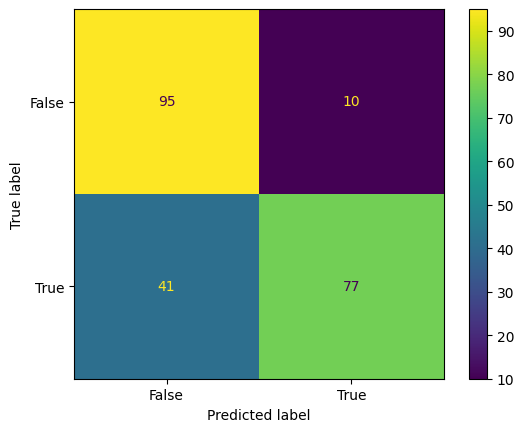

In [9]:
LSTM_Model(data_mode="MediaPipe",
           csv_path="../../../data/data_split_paths_CSVs/",
           data_dir="../../../data/visual_features/MediaPipe/mediaPipe_keypoints_data_UPD",
           lstm_features_size=100,
           inner_dense_size=32,
           epochs_num=100,
           batch_size=32,
           approach_type=None,
           threshold=0.5,
           train_verbose=False)

# OpenFace (Sequential only, since LSTM can only do sequences):


Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
-----------------------------------
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
-----------------------------------
(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 60ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

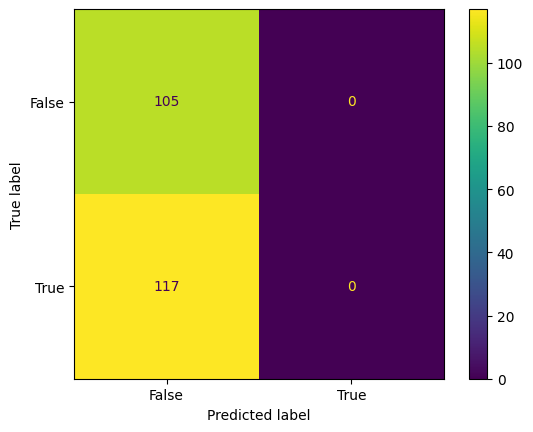

In [7]:
LSTM_Model(data_mode="OpenFace",
           csv_path="../../../data/data_split_paths_CSVs/",
           data_dir="../../../data/visual_features/OpenFace/PyFeatOutput/OpenFace",
           lstm_features_size=256,
           inner_dense_size=64,
           epochs_num=100,
           approach_type="sequential",
           batch_size=32,
           threshold=0.5,
           train_verbose=False)